In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,Input,add,SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import layers
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers.merge import concatenate


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
img_height, img_width, channel = train_features.shape[1],train_features.shape[2],train_features.shape[3]

In [0]:
img_height, img_width, channel

(32, 32, 3)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


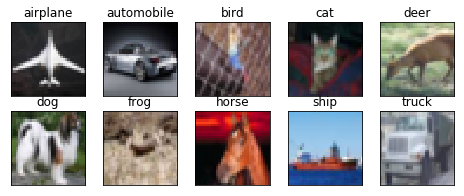

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Enas model

In [0]:
from keras.callbacks import  ModelCheckpoint  # importing checkpoint

filepath="/content/gdrive/My Drive/EVA_session_6-7.1_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"                                  # filepath in google drive to save weights
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)    # checkpoint to monitor validation accuracy, and save which give max accuracy

In [0]:
input = Input(shape=(img_height, img_width, channel,))

# Layer 1
x = SeparableConv2D(64, (5,5), strides=(1,1),activation='relu',padding='same',use_bias=False)(input)
x = BatchNormalization()(x)
Layer_1 = x

# Layer 2
x = Convolution2D(64, (5,5), strides=(1,1),activation='relu',padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
Layer_2 = x

# Layer 3
x = Convolution2D(64, (5,5), strides=(1,1),activation='relu',padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
Layer_3 = x

# Layer 4
x= concatenate([Layer_1, x])          # ------------------------------------------------------------------------ Skip connection here
x = SeparableConv2D(64, (5,5), strides=(1,1),activation='relu',padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
Layer_4 = x

#Pooling layer
x= concatenate([Layer_1, x])          # ------------------------------------------------------------------------ Skip connection here
x = MaxPooling2D(pool_size=(3, 3),strides=1,padding='same')(x)

# Layer 5
x = SeparableConv2D(64, (3,3), strides=(1,1),activation='relu',padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
Layer_5 = x

# Layer 6
x= concatenate([Layer_1,Layer_4, x])   # ------------------------------------------------------------------------ Skip connection here
x = SeparableConv2D(64, (5,5), strides=(1,1),activation='relu',padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
Layer_6 = x

# Layer 7
x= concatenate([Layer_1,Layer_3,Layer_4,Layer_5,x])   # ------------------------------------------------------------------------ Skip connection here
x = SeparableConv2D(64, (3,3), strides=(1,1),activation='relu',padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
Layer_7 = x

# Layer 8
x= concatenate([Layer_3,Layer_4, Layer_5,Layer_6,x])   # ------------------------------------------------------------------------ Skip connection here
x = SeparableConv2D(64, (5,5), strides=(1,1),activation='relu',padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
Layer_8 = x

#Pooling layer
x= concatenate([Layer_1,Layer_4,Layer_5,Layer_7, x])   # ------------------------------------------------------------------------ Skip connection here
x = MaxPooling2D(pool_size=(3, 3),strides=1,padding='same')(x)

# Layer 9
x= concatenate([Layer_6, x])   # ------------------------------------------------------------------------ Skip connection here
x = Convolution2D(64, (5,5), strides=(1,1),activation='relu',padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
Layer_9 = x

# Layer 10
x= concatenate([Layer_2,Layer_7, x])   # ------------------------------------------------------------------------ Skip connection here
x = SeparableConv2D(64, (5,5), strides=(1,1),activation='relu',padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
Layer_10 = x

# Layer 11
x= concatenate([Layer_2,Layer_3,Layer_4,Layer_5,Layer_9, x])   # ------------------------------------------------------------------------ Skip connection here
x = Convolution2D(64, (3,3), strides=(1,1),activation='relu',padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
Layer_11 = x

# Layer 12
x= concatenate([Layer_1,Layer_4,Layer_5,Layer_7,Layer_10, x])   # ------------------------------------------------------------------------ Skip connection here
x = SeparableConv2D(64, (5,5), strides=(1,1),activation='relu',padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
Layer_12 = x


output = concatenate([x,Layer_4,Layer_7,Layer_10])  # ------------------------------------------------------------------------ Skip connection here
output = GlobalAveragePooling2D()(output)
# output = Flatten()(x)
output = Dense(num_classes, activation='softmax')(output)


model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 64)   267         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   102400      batch_normalization_1[0][0]      
_____________________________________

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
390/390 [==============================] - 123s 316ms/step - loss: 1.3104 - acc: 0.5315 - val_loss: 1.2837 - val_acc: 0.5582

Epoch 00001: val_acc improved from -inf to 0.55820, saving model to /content/gdrive/My Drive/EVA_session_6-7.1_weights-improvement-01-0.56.hdf5
Epoch 2/50
390/390 [==============================] - 121s 309ms/step - loss: 0.9471 - acc: 0.6652 - val_loss: 1.2922 - val_acc: 0.5507

Epoch 00002: val_acc did not improve from 0.55820
Epoch 3/50
390/390 [==============================] - 120s 308ms/step - loss: 0.7755 - acc: 0.7278 - val_loss: 1.0337 - val_acc: 0.6690

Epoch 00003: val_acc improved from 0.55820 to 0.66900, saving model to /content/gdrive/My Drive/EVA_session_6-7.1_weights-improvement-03-0.67.hdf5
Epoch 4/50
390/390 [==============================] - 122s 314ms/step - loss: 0.6497 - acc: 0.7742 - val_loss: 0.7881 - val_acc: 0.7362

Epoch 00004: val_acc improved from 0.66900 to 0.73620, saving m

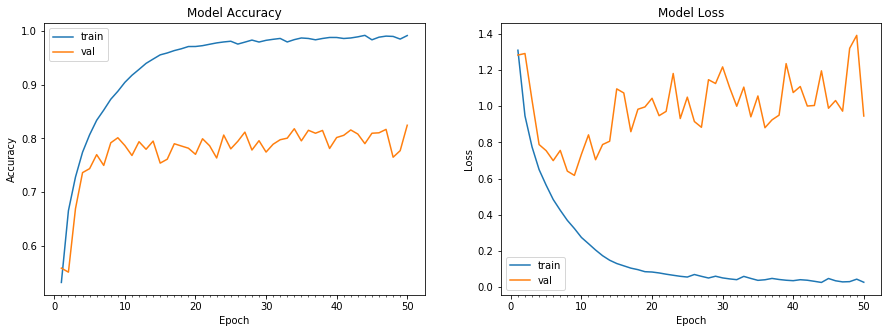

Accuracy on test data is: 82.45


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels),
                                 callbacks=[checkpoint],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Epoch 1/50
390/390 [==============================] - 115s 296ms/step - loss: 0.0208 - acc: 0.9934 - val_loss: 1.1219 - val_acc: 0.8058

Epoch 00001: val_acc did not improve from 0.82450
Epoch 2/50
390/390 [==============================] - 121s 309ms/step - loss: 0.0262 - acc: 0.9912 - val_loss: 1.1179 - val_acc: 0.7886

Epoch 00002: val_acc did not improve from 0.82450
Epoch 3/50
390/390 [==============================] - 121s 311ms/step - loss: 0.0381 - acc: 0.9864 - val_loss: 1.0922 - val_acc: 0.8039

Epoch 00003: val_acc did not improve from 0.82450
Epoch 4/50
390/390 [==============================] - 120s 308ms/step - loss: 0.0229 - acc: 0.9925 - val_loss: 1.2714 - val_acc: 0.7954

Epoch 00004: val_acc did not improve from 0.82450
Epoch 5/50
390/390 [==============================] - 120s 308ms/step - loss: 0.0270 - acc: 0.9908 - val_loss: 1.3400 - val_acc: 0.7833

Epoch 00005: val_acc did not improve from 0.82450
Epoch 6/50
390/390 [==============================] - 120s 308ms/

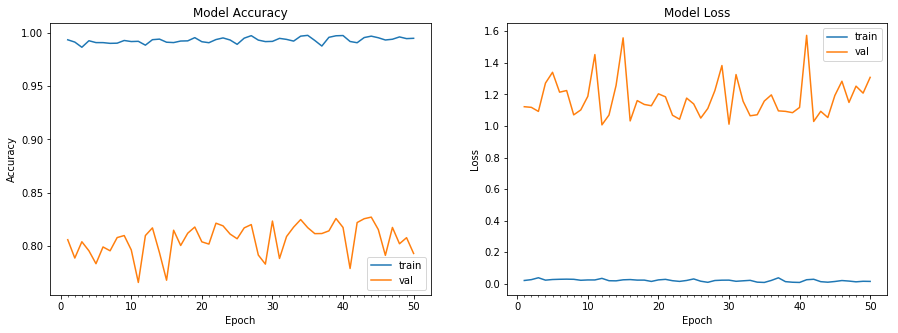

Accuracy on test data is: 79.29


In [0]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels),
                                 callbacks=[checkpoint],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))